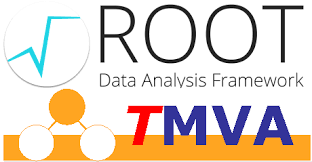

# Machine Learning using ROOT's TMVA

Author : Muhammad Hilmi

The Toolkit for Multivariate Data Analysis with ROOT (TMVA) provides a machine learning environment for the processing and evaluation of multivariate classification. TMVA helps a lot for application in high-energy physics. 

#### TMVA User Interface

Here is the specification for classification training and test data in ROOT tree format with signal and background events.

This notebook will shows the flow of doing Machine Learning in ROOT-TMVA to identify quarks jets and gluons jets.

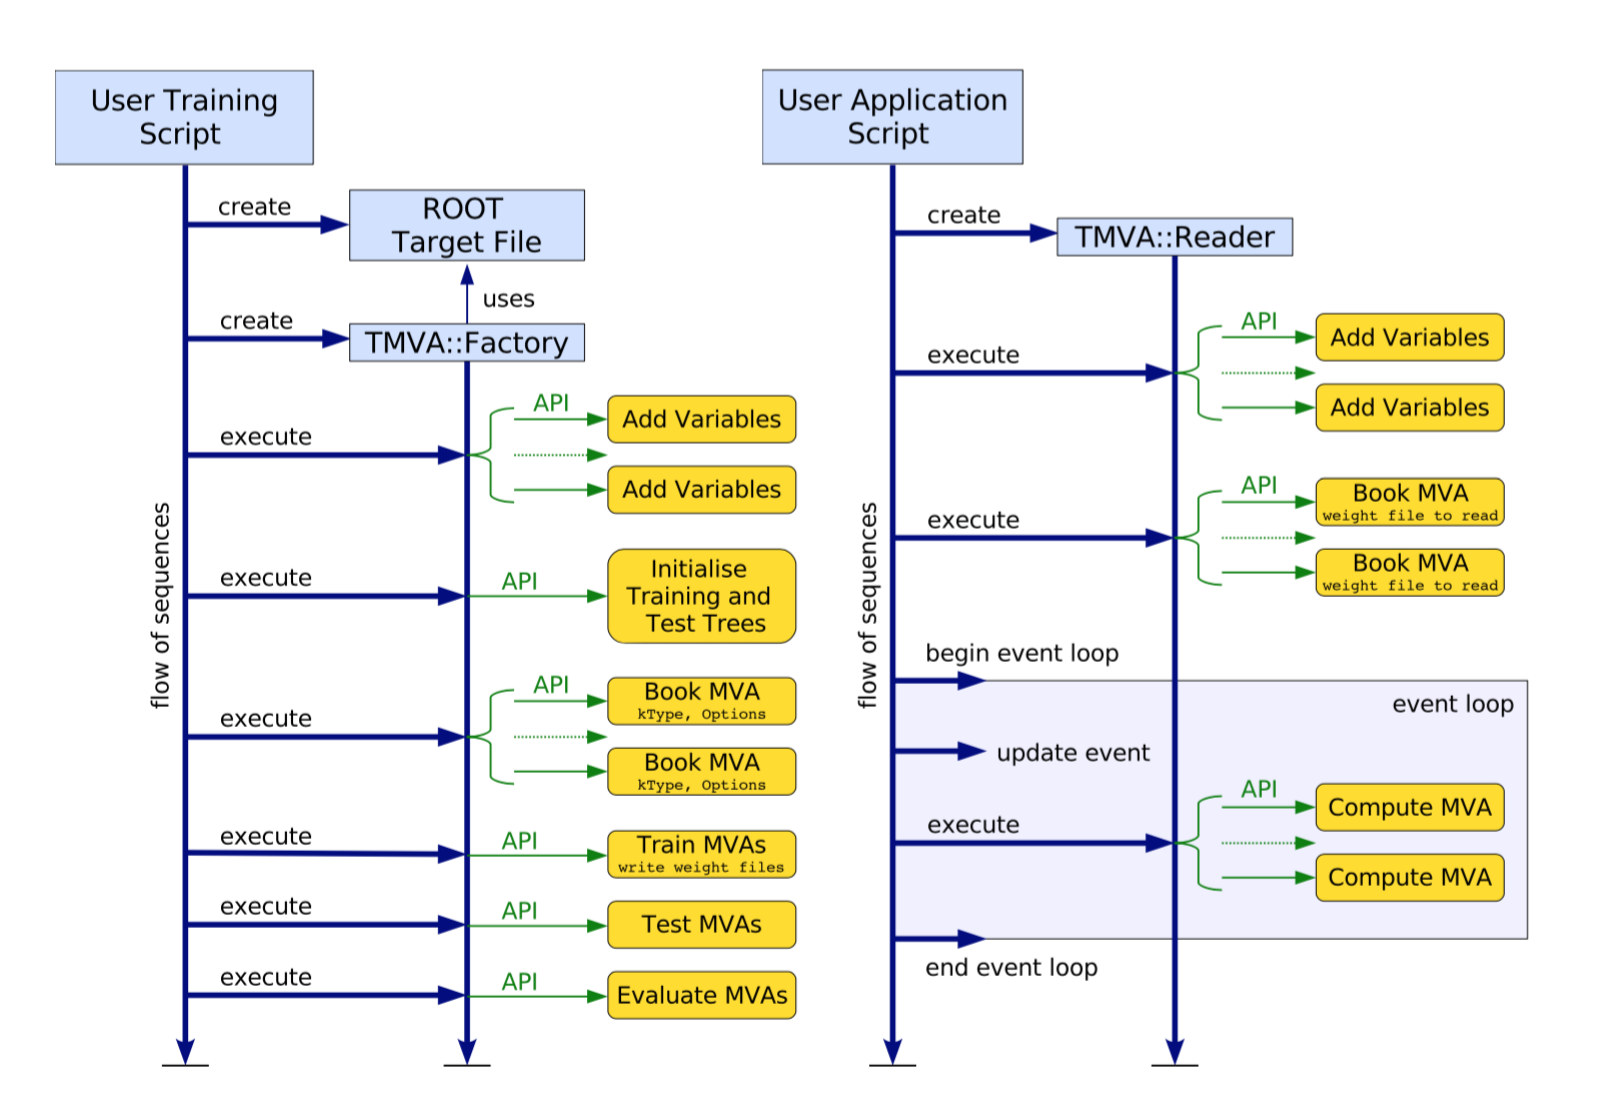

This notebook will cover on packages of ROOT-TMVA:
- Boosted Decision Tree
- Support Vector Machine
- Likelihood
- Artificial Neural Networks
- Deep Neural Networks


In [2]:
import ROOT

import numpy as np
import pandas as pd 

Welcome to JupyROOT 6.24/02


In [3]:
import os, sys, glob, collections

ROOT.gROOT.SetBatch()
ROOT.gStyle.SetOptStat(0)
ROOT.TMVA.Tools.Instance()

####  Output file for the trained dataset 

The file created is used to analyse the result

In [4]:
MethodName 	= "ML"
outFileName	= MethodName + "_output.root"
outputFile 	= ROOT.TFile(outFileName, "RECREATE")

#### Declaring Signal Tree

The signal Tree is created by a chain that have collections of files containg TTree objects from the jetTree

In [5]:
sigTree	= ROOT.TChain('jetTree')

#### Accessing the open data

In this notebook, we are only using the first root file as the RootTargetFile to book the 5 methods that have been mentioned earlier. However, you can still run all the 3 root file for Boosted Decision Tree, Likelihood, and Deep Neural Network methods only.

In [6]:
inFileName 	= '../files/JetNtuple_RunIISummer16_13TeV_MC_'

for ifile in range (1,2):
	sigTree.Add(inFileName+str(ifile)+"_skimmed.root")

#### ROOT TMVA Data Loader and Factory

We need to start by initializing TMVA and build a Factory which holds our analysis, and loading the data with a DataLoader. 
The input data sets used for training and testing of the multivariate methods need to be handed to the Factory. 

TMVA supports ROOT TTree and derived TChain objects and text files. If ROOT Trees are used for classification problems, the signal and background events can be located in the same or in different trees. Data trees can be provided specifically for the purpose of either training or testing or for both purposes.

In [7]:
dataLoader	= ROOT.TMVA.DataLoader("dataset")
factory		= ROOT.TMVA.Factory(MethodName + "_Train", outputFile, "!V:!Silent:Color:DrawProgressBar:Transformations=I;D;P;G,D:AnalysisType=Classification")

####  JetTree for Signal and Background

The data Loader that is created will holds the actual signal and background events.
The signal cut identify the particles that is Quarks and the background cut identify the particles that is Gluon.

In [8]:
bkgTree = sigTree.Clone("tree_bkg")

sigCut 	= "(isPhysUDS==1)"
bkgCut	= "(isPhysG==1)"

dataLoader.AddSignalTree(sigTree)
dataLoader.AddBackgroundTree(bkgTree)

dataLoader.Print()

DataSetInfo              : [dataset] : Added class "Signal"
                         : Add Tree jetTree of type Signal with 28614 events
DataSetInfo              : [dataset] : Added class "Background"
                         : Add Tree tree_bkg of type Background with 28614 events
OBJ: TMVA::DataLoader	dataset	Configurable


#### Declaring variable for data Loader

The variable is chosen to observe and to identify the quarks and gluons.
It is determined by certain requirements:

1. Multiplicities

    Jet multiplicity is the number of particles contained in the jets. Gluon have higher values of multiplicities than quark. The simplest and most studied variable that can be used is the multiplicity, i.e. the total number of PFCandidates reconstructed within the jet.

2. Jet Shapes

    Quark jets are expected to produce narrower jets and therefore lower values of the axes variables (with respect to gluon jets of the same pTD)
    

3. Fragmentation function 

    Quarks have a harder fragmentation function compared to gluons and are therefore more likely to produce jets with hard constituents that carry a significant fraction of the jet energy. So, quarks have higher pTD (transverse momentum of a particle and the sum of an integer is over the jet's constituents) than gluons.

In [9]:
varList = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']
for var in varList:
	dataLoader.AddVariable(var)

#### Weight for Signal and Background

Individual events can be weighted, with the weights being a column or a function of columns of the input data sets.

In [10]:
dataLoader.SetSignalWeightExpression("eventWeight")
dataLoader.SetBackgroundWeightExpression("eventWeight")

#### Prepare to Training and Test Tree

The input events that are handed to the Factory are internally copied and split into one training and one test ROOT tree. The Tree must be trained to guarantees a statistically independent evaluation of the MVA algorithms based on the test sample.

In [11]:
dataLoader.PrepareTrainingAndTestTree(sigCut, bkgCut, "SplitMode=Random:NormMode=NumEvents:!V")

### Booking Method of Factory 

All TMVA-ROOT methods are booked via the Factory by specifying the method’s type, plus a unique namechosen by the user, and a set of specific configuration options encoded in a string qualifier.

****Boosted Decision Tree****

Boosting stabilizes the response of the decision trees with respect to fluctuations in the training sample and is able to
considerably enhance the performance. The type of boost used here is Grad.

You can find out more on Boosted Decision Tree in ML_BDT from Alma's notebook.

In [12]:
factory.BookMethod(dataLoader, ROOT.TMVA.Types.kBDT, "BDTG", "!H:!V:NTrees=1000:MinNodeSize=2.5%:BoostType=Grad:Shrinkage=0.10:UseBaggedBoost:BaggedSampleFraction=0.5:nCuts=20:MaxDepth=2")

Factory                  : Booking method: BDTG
                         : 
                         : the option NegWeightTreatment=InverseBoostNegWeights does not exist for BoostType=Grad
                         : --> change to new default NegWeightTreatment=Pray
                         : Building event vectors for type 2 Signal
                         : Dataset[dataset] :  create input formulas for tree jetTree
                         : Dataset[dataset] :  create input formulas for tree jetTree
                         : Building event vectors for type 2 Background
                         : Dataset[dataset] :  create input formulas for tree jetTree
                         : Dataset[dataset] :  create input formulas for tree jetTree
DataSetFactory           : [dataset] : Number of events in input trees
                         : Dataset[dataset] :     Signal     requirement: "(isPhysUDS==1)"
                         : Dataset[dataset] :     Signal          -- number of events p

****Likelihood****

This method is using Projective Likelihood Estimator (PDE).This method which is maximum likelihood consists of building a model out of probability density functions that reproduces the input variables for signal and background. 

For a given event, the likelihood for being of signal type is obtained by multiplying the signal probability densities of all input variables, which are assumed to be independent, and normalising this by the sum of the signal and background likelihoods.

The training and the application of the likelihood classifier are very fast operations, thus, it is suitable for large data sets.

In [13]:
factory.BookMethod(dataLoader, ROOT.TMVA.Types.kLikelihood, "LikelihoodKDE", "!H:!V:!TransformOutput:PDFInterpol=KDE:KDEtype=Gauss:KDEiter=Adaptive:KDEFineFactor=0.3:KDEborder=None:NAvEvtPerBin=50")

Factory                  : Booking method: LikelihoodKDE
                         : 


****Support Vector Machine****

The main idea of the SVM approach to classification problems is to build a hyperplane that separates signal and background vectors (events) using only a minimal subset of all training vectors (support vectors). 

You can find out more on Support Vector Machine in ML_SVM from Sarvin's notebook.

In [14]:
factory.BookMethod(dataLoader, ROOT.TMVA.Types.kSVM, "SVM", "")

Factory                  : Booking method: SVM
                         : 


****Artificial Neural Networks****

An Artificial Neural Network (ANN) is simulated collection of interconnected neurons, with each neuron producing a certain response at a given set of input signals. There is few types of neural networks such as The Clermont-Ferrand, ROOT and MLP neural network.

In this notebook, the booking method used is The ROOT neural network (class TMultiLayerPerceptron). The advantages of using this method are:
- No limitation on the number of layers/neurons
- Allows to save the network in a root file, and provides more export functionalities
- It gives more flexibility regarding the normalization of inputs/outputs

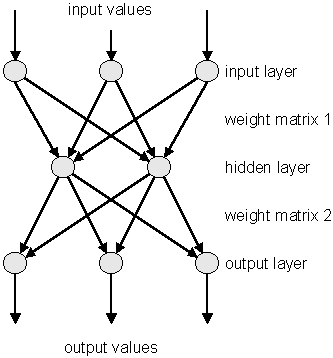

In [15]:
factory.BookMethod(dataLoader, ROOT.TMVA.Types.kTMlpANN, "TMlp_ANN", "" )

Factory                  : Booking method: TMlp_ANN
                         : 
                         : Use 200 training cycles
                         : Use configuration (nodes per hidden layer): :5:4:


****Deep Neural Networks****

A deep neural network (DNN) is an artificial neural network with several hidden layers and a large number of neurons in each layer. The deep neural network implementation provides an optimized implementation of feed-forward multilayer perceptrons that can be efficiently trained on modern multi-core and GPU architectures.

The advantages are these networks are capable of learning complex, non-linear relations when trained on a sufficiently large amount of training data.

The training of the deep neural network is performed in one or multiple training phases. A training
phase ends when the test error did not decrease for a user-specified number of epoch.

This booking method splits the TMVA training set in a sub-training set used to:
- To compute the gradient and update the weights 
- Validation set is created to compute the error. 

To properly evaluate the performance, the model is later evaluated on a completely separate data set, the TMVA test set.

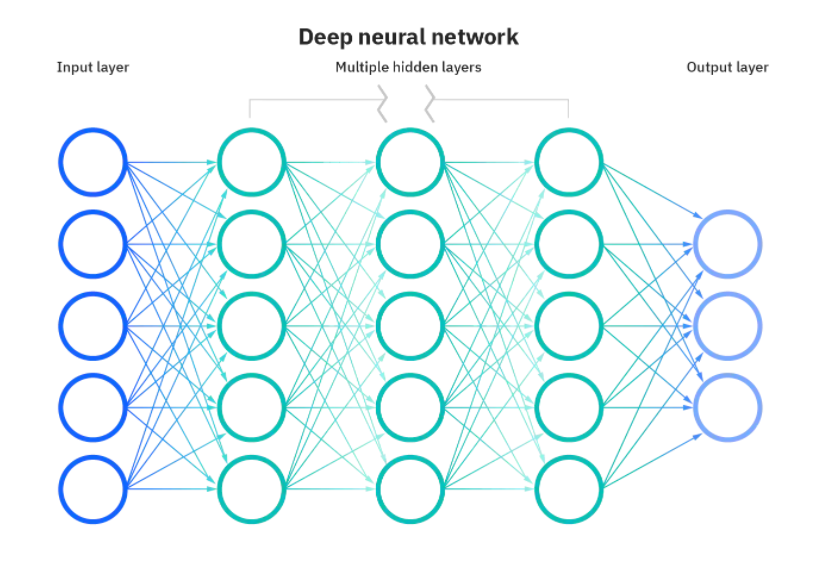

In [16]:
factory.BookMethod(dataLoader, ROOT.TMVA.Types.kDL, "DNN", )

Factory                  : Booking method: DNN
                         : 
                         : Will now use the CPU architecture with BLAS and IMT support !


#### Training dataset

The trained TMVA methods are applied to the test data set and its provide scalar outputs according to which an event can be classified as either signal or background. The TMVA outputs are stored in the test tree (TestTree) to which a column is added for each booked method. The tree is eventually written to the output file and can be directly analysed in a ROOT session.

The Factory and data set classes of TMVA perform a preliminary property assessment of the input variables used by the TMVA methods, such as computing correlation coefficients and ranking the variables according to their separation (for classification)

In [17]:
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

ROOT.TMVA.TMVAGui(outFileName)
outputFile.Close()

Factory                  : Train all methods
Factory                  : [dataset] : Create Transformation "I" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'jetPt' <---> Output : variable 'jetPt'
                         : Input : variable 'jetEta' <---> Output : variable 'jetEta'
                         : Input : variable 'QG_mult' <---> Output : variable 'QG_mult'
                         : Input : variable 'QG_ptD' <---> Output : variable 'QG_ptD'
                         : Input : variable 'QG_axis2' <---> Output : variable 'QG_axis2'
Factory                  : [dataset] : Create Transformation "D" with events from all classes.
                         : 
                         : Transformation, Variable selection : 
                         : Input : variable 'jetPt' <---> Output : variable 'jetPt'
                         : Input : variable 'jetEta' <---> Ou

0%, time left: unknown
6%, time left: 3 sec
12%, time left: 3 sec
18%, time left: 2 sec
25%, time left: 2 sec
31%, time left: 2 sec
37%, time left: 2 sec
43%, time left: 2 sec
50%, time left: 1 sec
56%, time left: 1 sec
62%, time left: 1 sec
68%, time left: 1 sec
75%, time left: 0 sec
81%, time left: 0 sec
87%, time left: 0 sec
93%, time left: 0 sec
0%, time left: unknown
6%, time left: 0 sec
12%, time left: 0 sec
18%, time left: 0 sec
25%, time left: 0 sec
31%, time left: 0 sec
37%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
56%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
81%, time left: 0 sec
88%, time left: 0 sec
94%, time left: 0 sec
0%, time left: unknown
6%, time left: 0 sec
12%, time left: 0 sec
18%, time left: 0 sec
25%, time left: 0 sec
31%, time left: 0 sec
37%, time left: 0 sec
44%, time left: 0 sec
50%, time left: 0 sec
56%, time left: 0 sec
63%, time left: 0 sec
69%, time left: 0 sec
75%, time left: 0 sec
81%, time 

### ROC and KST graph
The Receiver Operator Characteristic (ROC) curve is an evaluation metric for binary classification problems.

There will be 2 graphs:
- ROC: Background rejection versus signal efficiency obtained by cutting on the classifier outputs for the events of the test sample.

- TMVA Output for Classifier: Plots for classifier output distributions for signal and background events

#### Plotting the graph of ROC and KST

In [18]:
from plotting_helpers import *

colors = [ROOT.kGreen+2, ROOT.kBlue+2, ROOT.kRed+2, ROOT.kMagenta+2, ROOT.kYellow+2]

METHOD     = "ML"
FILENAME   = METHOD + "_output.root" 
#OUTDIR     = "./PNG/"

PLOT_ROC = True
PLOT_KST = True

TAIL = ".png"

In [19]:
file    = ROOT.TFile(FILENAME, "OPEN")
dataset = file.Get("dataset")
  
hNameROC = "_rejBvsS" # name of ROC histograms
hNameKST = "_Train"   # training histograms

xTitle = "Signal Efficiency"
yTitle = "Background Rejection"
fTitle = yTitle + " versus " + xTitle

methodDict = {}
methodDict["mother"] = {}
methodDict["daughter"] = {}
histoList  = {}
histoDict  = {}

#
# Access first directory to obtain keys for 2nd directory
#
keyList = dataset.GetListOfKeys()

for key in keyList:
    if "Method" in key.GetName():        
        methodDict["mother"][key.GetName()] = dataset.Get(key.GetName())

In [20]:
#
# Retrieve histograms for plotting
#
for method in methodDict["mother"]:

    keyList = methodDict["mother"][method].GetListOfKeys()

    for methodKey in keyList:
        methodName = methodKey.GetName()
        histoDict[methodName] = {}
        methodDict["daughter"][methodName] = methodDict["mother"][method].Get(methodName)

        #
        # Clone histograms
        #
        histoDict[methodName]["ROC"]      = methodDict["daughter"][methodName].Get("MVA_"+methodName+hNameROC     ).Clone()
        histoDict[methodName]["SigTrain"] = methodDict["daughter"][methodName].Get("MVA_"+methodName+hNameKST+"_S").Clone()
        histoDict[methodName]["BkgTrain"] = methodDict["daughter"][methodName].Get("MVA_"+methodName+hNameKST+"_B").Clone()
        histoDict[methodName]["SigTest"]  = methodDict["daughter"][methodName].Get("MVA_"+methodName+"_S"         ).Clone()
        histoDict[methodName]["BkgTest"]  = methodDict["daughter"][methodName].Get("MVA_"+methodName+"_B"         ).Clone()

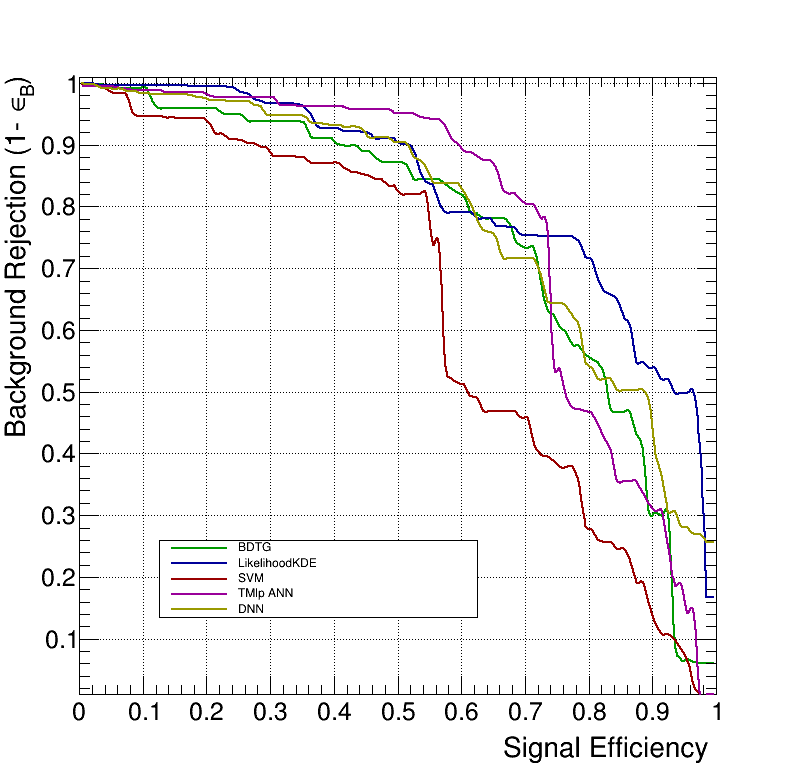

In [21]:
#
# Declare ROC canvas with grids, and the corresponding attributes
#
canv = ROOT.TCanvas("canvROC", "canv", 800, 800)
canv.SetGrid()
canv.SetTicks()

#
# Plot legends and histograms
#
lgd = ROOT.TLegend(0.2, 0.2, 0.6, 0.3)

i = 0
for methodName in histoDict:
    histo = histoDict[methodName]["ROC"]
    histo.SetLineColor(colors[i])
    FormatAxisText(histo, xTitle="Signal Efficiency", yTitle="Background Rejection (1-#epsilon_{B})", yOffset=1.2)
    histo.GetXaxis().SetRangeUser(0., 1.0)
    histo.SetMaximum(1.01)
    histo.SetMinimum(0.01)
    histo.SetTitle("")
    histo.SetLineWidth(2)
    histo.Draw("csame")

    lgd.AddEntry(histo, methodName.replace("_", " "), "l")
    i += 1

lgd.Draw()
# canv.SetLogy()
canv.Draw()



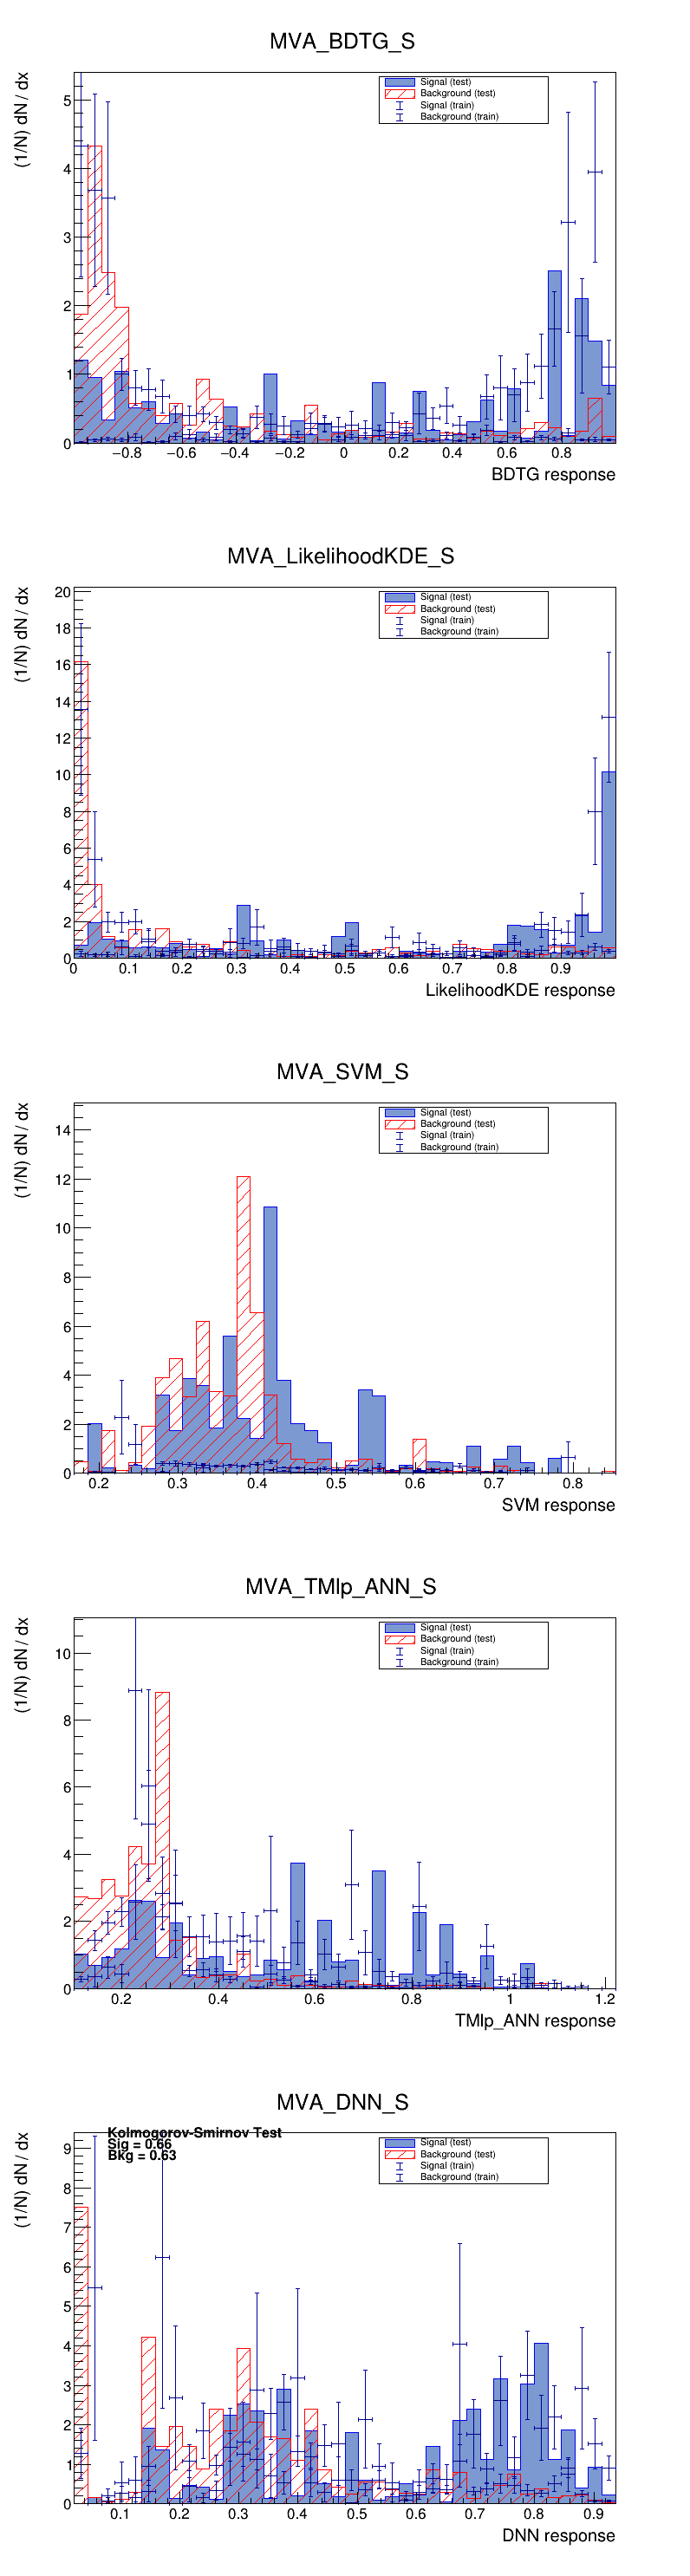

In [22]:
canv = ROOT.TCanvas("canv", "", 800, 3000)
canv.Divide(1,5)

lgd = {}
frame = {}

j = 1
for methodName in histoDict:                                        
    
    canv.cd(j)
    
    #
    # Setup legends and histograms
    #
    lgd[methodName] = ROOT.TLegend(0.55, 0.79, 0.8, 0.89)

    ROOT.TMVA.TMVAGlob.NormalizeHists(histoDict[methodName]["SigTrain"], histoDict[methodName]["BkgTrain"])
    ROOT.TMVA.TMVAGlob.NormalizeHists(histoDict[methodName]["SigTest"],  histoDict[methodName]["BkgTest"])
    ROOT.TMVA.TMVAGlob.SetSignalAndBackgroundStyle(histoDict[methodName]["SigTest"],  histoDict[methodName]["BkgTest"])
    histoDict[methodName]["SigTest"].SetLineWidth(1)
    histoDict[methodName]["BkgTest"].SetLineWidth(1)

    #
    # Setup frame
    #
    frame[methodName] = SetupFrame(histoDict[methodName]["SigTest"], histoDict[methodName]["BkgTest"], methodName)
    frame[methodName].Draw()

    canv.GetPad(0).SetLeftMargin(0.105)
    frame[methodName].GetYaxis().SetTitleOffset(1.2)

    #
    # Overlay signal and background test histos
    #
    histoDict[methodName]["SigTest"].Draw("same hist")
    histoDict[methodName]["BkgTest"].Draw("same hist")
    histoDict[methodName]["SigTrain"].Draw("e1 same")
    histoDict[methodName]["BkgTrain"].Draw("e1 same")

    lgd[methodName].AddEntry(histoDict[methodName]["SigTest"],  "Signal (test)",      "F")
    lgd[methodName].AddEntry(histoDict[methodName]["BkgTest"],  "Background (test)",  "F")
    lgd[methodName].AddEntry(histoDict[methodName]["SigTrain"], "Signal (train)",     "E1")
    lgd[methodName].AddEntry(histoDict[methodName]["BkgTrain"], "Background (train)", "E1")

    #
    # K-S Test
    #
    kolS = histoDict[methodName]["SigTest"].KolmogorovTest(histoDict[methodName]["SigTrain"], "X")
    kolB = histoDict[methodName]["BkgTest"].KolmogorovTest(histoDict[methodName]["BkgTrain"], "X")

    tt1    = ROOT.TText(0.15, 0.89,   "Kolmogorov-Smirnov Test")
    tt2    = ROOT.TText(0.15, 0.865, "Sig = "+str(kolS))
    tt3    = ROOT.TText(0.15, 0.84,  "Bkg = "+str(kolB))

    for text in [tt1, tt2, tt3]:
        text.SetNDC()
        text.SetTextSize(0.032)
        text.AppendPad()


    lgd[methodName].Draw()
    frame[methodName].Draw("same axis")
    j += 1

canv.Draw()


In order to fairly compare our newly trained model and the traditional likelihood discriminator, we should look at the corresponding receiver operating characteristic (ROC) curves. 

However, in this file we are only accessing the data from the first root file. It is better to used more datas to have a smoother curves for ROC.

In this notebook, we could seen that the artificial neural network produces a better ROC curves.

**The larger the area under the curve (AUC), the better the performance of the classifier, the better the separation of
signal and background which can be achieved.**